In [1]:
# 1.数据处理
import sys, os
sys.path.append(os.path.abspath(".."))  # 确保当前目录加入路径

from models.DataPreprocessor import get_plans_dict, DataPreprocessor, plan_trees_to_graphs, graphs_to_df, df_to_graphs

json_path = "../data/train_plan_*.csv"
plans_dict, execution_times = get_plans_dict(json_path)
print("plans_dict:\n", plans_dict[0:5])
print("execution_times:\n", execution_times[0:5])

preprocessor = DataPreprocessor()
plans_tree = preprocessor.preprocess_all(plans_dict)

edges_list, matrix_plans = plan_trees_to_graphs(plans_tree, add_self_loops=True, undirected=False)
print(matrix_plans[0][0])
print(matrix_plans[0][1])
print(edges_list[0])
print(edges_list[99])

plans_df = graphs_to_df(matrix_plans)
plans_df.to_csv("../data/process/01_plans_df.csv", index=False)
plans_df.head()

找到的文件: ['../data/train_plan_part17.csv', '../data/train_plan_part8.csv', '../data/train_plan_part6.csv', '../data/train_plan_part3.csv', '../data/train_plan_part19.csv', '../data/train_plan_part9.csv', '../data/train_plan_part11.csv', '../data/train_plan_part1.csv', '../data/train_plan_part0.csv', '../data/train_plan_part18.csv', '../data/train_plan_part10.csv', '../data/train_plan_part12.csv', '../data/train_plan_part16.csv', '../data/train_plan_part15.csv', '../data/train_plan_part2.csv', '../data/train_plan_part14.csv', '../data/train_plan_part5.csv', '../data/train_plan_part7.csv', '../data/train_plan_part13.csv', '../data/train_plan_part4.csv']
总数据行数: 100000
df:
       id                                               json
0  85000  {"Plan": {"Node Type": "Bitmap Heap Scan", "Pa...
1  85001  {"Plan": {"Node Type": "Gather", "Parallel Awa...
2  85002  {"Plan": {"Node Type": "Hash Join", "Parallel ...
3  85003  {"Plan": {"Node Type": "Gather", "Parallel Awa...
4  85004  {"Plan": {"No

,plan_id,node_idx,Node Type,Parallel Aware,Relation Name,Alias,Startup Cost,Total Cost,Plan Rows,Plan Width,...,Peak Memory Usage,Filter,Rows Removed by Filter,Join Filter,Rows Removed by Join Filter,Merge Cond,Sort Key,Sort Method,Sort Space Used,Sort Space Type
0,0,0,Bitmap Heap Scan,False,movie_keyword,mk,11788.77,49094.94,1028173,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,Bitmap Index Scan,False,NaN,NaN,0.00,11531.73,1028173,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,Gather,False,NaN,NaN,59038.23,292179.55,958880,136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,Hash Join,True,NaN,NaN,58038.23,195291.55,399533,136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2,Index Scan,True,cast_info,ci,0.44,96872.38,1832141,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
from models.DataPreprocessor import safe_cond_parse

NEED_PARSE_COND_SCAN = [
    "Filter",
    "Index Cond",
    "Recheck Cond"
]

NEED_PARSE_COND_JOIN = [
    "Hash Cond",
    "Join Filter",
    "Merge Cond",
]

NEED_PARSE_COND_COLS = NEED_PARSE_COND_SCAN + NEED_PARSE_COND_JOIN

for col in NEED_PARSE_COND_COLS:
    plans_df[f"{col}_Split"] = plans_df[col].apply(safe_cond_parse)

plans_df.to_csv("../data/process/plans_df_parsed.csv", index=False)



In [3]:

for col in NEED_PARSE_COND_COLS:
    max_and = 0
    for j in plans_df[f"{col}_Split"]:
        if len(j) > max_and:
            max_and = len(j)
    print(col, max_and)

for col in NEED_PARSE_COND_COLS:
    c = 0
    for j in plans_df[f"{col}_Split"]:
        if j != [] and c < 3:
            print(col, j)
            c += 1
       


Filter 2
Index Cond 1
Recheck Cond 2
Hash Cond 1
Join Filter 1
Merge Cond 1
Filter [['kind_id', '<', 7], ['production_year', '>', 1999]]
Filter [['keyword_id', '<', 15855]]
Filter [['kind_id', '=', 7]]
Index Cond [['keyword_id', '>', 17243]]
Index Cond [['role_id', '=', 10]]
Index Cond [['company_type_id', '>', 1]]
Recheck Cond [['keyword_id', '>', 17243]]
Recheck Cond [['keyword_id', '>', 50942]]
Recheck Cond [['company_id', '>', 94928]]
Hash Cond [['ci.movie_id', '=', 't.id']]
Hash Cond [['mk.movie_id', '=', 't.id']]
Hash Cond [['mc.movie_id', '=', 't.id']]
Join Filter [['t.id', '=', 'mc.movie_id']]
Join Filter [['t.id', '=', 'mc.movie_id']]
Join Filter [['t.id', '=', 'ci.movie_id']]
Merge Cond [['t.id', '=', 'mi_idx.movie_id']]
Merge Cond [['t.id', '=', 'mk.movie_id']]
Merge Cond [['t.id', '=', 'mc.movie_id']]


In [6]:
import pandas as pd
db_info = pd.read_csv("../data/column_min_max_vals.csv")
db_info.head()
db_info["table_name"], db_info["column_name"] = db_info["name"].str.split(".").str[0], db_info["name"].str.split(".").str[1]
db_info.head()


,name,min,max,cardinality,num_unique_values,table_name,column_name
0,t.id,1,2528312,2528312,2528312,t,id
1,t.kind_id,1,7,2528312,6,t,kind_id
2,t.production_year,1880,2019,2528312,133,t,production_year
3,mc.id,1,2609129,2609129,2609129,mc,id
4,mc.company_id,1,234997,2609129,234997,mc,company_id


In [7]:
for idx, row in plans_df.iterrows():
    if (row["Relation Name"] != "") != (row["Alias"] != ""):
        print(row["Relation Name"], row["Alias"])
        assert False


In [8]:
# 将node_type转换为id
node_type = plans_df["Node Type"].unique()
print(node_type, len(node_type))
node_type_mapping = {k : i for i, k in enumerate(node_type)}
plans_df["NodeType_id"] = plans_df["Node Type"].map(node_type_mapping)
print(plans_df[["Node Type", "NodeType_id"]].head())


['Bitmap Heap Scan' 'Bitmap Index Scan' 'Gather' 'Hash Join' 'Index Scan'
 'Hash' 'Seq Scan' 'Nested Loop' 'Merge Join' 'Gather Merge' 'Materialize'
 'BitmapAnd' 'Sort'] 13
           Node Type  NodeType_id
0   Bitmap Heap Scan            0
1  Bitmap Index Scan            1
2             Gather            2
3          Hash Join            3
4         Index Scan            4


In [9]:
def df_to_plans(df: pd.DataFrame, keep_extra_cols=False) -> list[list[dict]]:
    orig_cols = [c for c in df.columns if c not in {"plan_id", "node_idx"}]
    cols = orig_cols if not keep_extra_cols else [c for c in df.columns if c not in {"plan_id", "node_idx"}]

    out = []
    for pid, g in df.sort_values(["plan_id","node_idx"], kind="stable").groupby("plan_id", sort=True):
        plan_nodes = []
        for _, row in g.sort_values("node_idx", kind="stable").iterrows():
            d = {}
            for k in cols:
                v = row[k]
                if v is None or []:
                    continue
                d[k] = v
            plan_nodes.append(d)
        out.append(plan_nodes)
    return out

new_matrix_plans = df_to_plans(plans_df)
new_matrix_plans[0][0]

{'Node Type': 'Bitmap Heap Scan',
 'Parallel Aware': False,
 'Relation Name': 'movie_keyword',
 'Alias': 'mk',
 'Startup Cost': 11788.77,
 'Total Cost': 49094.94,
 'Plan Rows': 1028173,
 'Plan Width': 12,
 'Actual Startup Time': 41.924,
 'Actual Total Time': 200.35,
 'Actual Rows': 1029758,
 'Actual Loops': 1,
 'Recheck Cond': '(keyword_id > 17243)',
 'Rows Removed by Index Recheck': 0.0,
 'Exact Heap Blocks': 24037.0,
 'Lossy Heap Blocks': 0.0,
 'Parent Relationship': nan,
 'Index Name': nan,
 'Index Cond': nan,
 'Workers Planned': nan,
 'Workers Launched': nan,
 'Single Copy': nan,
 'Join Type': nan,
 'Inner Unique': nan,
 'Hash Cond': nan,
 'Workers': nan,
 'Scan Direction': nan,
 'Hash Buckets': nan,
 'Original Hash Buckets': nan,
 'Hash Batches': nan,
 'Original Hash Batches': nan,
 'Peak Memory Usage': nan,
 'Filter': nan,
 'Rows Removed by Filter': nan,
 'Join Filter': nan,
 'Rows Removed by Join Filter': nan,
 'Merge Cond': nan,
 'Sort Key': nan,
 'Sort Method': nan,
 'Sort Spa

In [10]:
# NodeVectorizer
import re, math
from collections import defaultdict
import numpy as np
import torch
from typing import List

from models.Utils import process_join_cond_field, process_index_cond_field, load_column_stats


node_type_list = ['Bitmap Heap Scan', 'Bitmap Index Scan', 'BitmapAnd', 'Gather', 'Gather Merge', 'Hash', 'Hash Join', 'Index Scan', 'Materialize', 'Merge Join', 'Nested Loop', 'Seq Scan', 'Sort']
parallel_list = [True, False]
plan_rows_max = 2*10**8

def NodeVectorizer(matrix_plans : List[List[dict]]) -> List[List[List[List]]]:
    res = []
    for mp in matrix_plans:
        plan_matrix = []
        for node in mp:
            node_vector = [0] * (len(node_type_list) + 2 + 1)
            offset = 0
            # 1. node_type
            node_vector[node_type_mapping[node["Node Type"]] + offset] = 1
            offset += len(node_type_list)
            # 2. parallel
            node_vector[parallel_list.index(node["Parallel Aware"]) + offset] = 1
            
            offset += len(parallel_list)
            # 3. rows
            node_vector[offset] = node["Plan Rows"] / plan_rows_max
            plan_matrix.append(node_vector)
        res.append(plan_matrix)
    return res

res = NodeVectorizer(new_matrix_plans)
print("NodeType[13] : parallel[2] : rows[1]")
print(len(res[0]))
print(len(res[0][0]))
print(res[0][0])



NodeType[13] : parallel[2] : rows[1]
2
16
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.005140865]


In [11]:
# 模型搭建

import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch

class NodeEncoder(nn.Module):
    """
    输入: data.x 形状 [N, F_in]
    输出: node_embs [N, d_node]
    """
    def __init__(self, in_dim: int, d_node: int):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, d_node),
            nn.ReLU(),
            nn.LayerNorm(d_node),
        )
    def forward(self, x):
        return self.proj(x)

# ---- 组合总模型 ----
class PlanCostModel(nn.Module):
    """
    NodeEncoder → GATTreeEncoder → PredictionHead
    """
    def __init__(self, nodecoder: nn.Module, treeencoder: nn.Module, predict_head: nn.Module):
        super().__init__()
        self.nodecoder = nodecoder
        self.treeencoder = treeencoder
        self.predict_head = predict_head

    def forward(self, data: Data | Batch):
        """
        期望 data 里至少有:
        - x: [N, F_num] (numerical features)
        - x_cat: [N, F_cat] (categorical features)
        - edge_index: [2, E]
        - batch: [N]  指示每个节点属于哪张图
        """
        x = self.nodecoder(data.x)                                   # [N, d_node]
        g = self.treeencoder(x, data.edge_index, data.batch)         # [B, d_graph]
        y = self.predict_head(g)                                     # [B, out_dim]
        return y


from models.TreeEncoder import GATTreeEncoder
from models.PredictionHead import PredictionHead
# ---- 使用示例 ----
# 使用正确的数值特征维度
F_num = 16
d_node, d_graph = 32, 64
nodecoder = NodeEncoder(
    in_dim=F_num,
    d_node=d_node
)
gatTreeEncoder = GATTreeEncoder(
    input_dim=d_node,      # 一定用实际特征维度
    hidden_dim=64,
    output_dim=d_graph,
    num_layers=3,
    num_heads=4,
    dropout=0.1,
    pooling="mean"
)
predict_head = PredictionHead(d_graph, out_dim=1)
model = PlanCostModel(nodecoder, gatTreeEncoder, predict_head)


In [12]:

print(type(res))
print(type(edges_list))
print(model)


<class 'list'>
<class 'list'>
PlanCostModel(
  (nodecoder): NodeEncoder(
    (proj): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): ReLU()
      (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
  )
  (treeencoder): GATTreeEncoder(
    (convs): ModuleList(
      (0): GATConv(32, 64, heads=4)
      (1-2): 2 x GATConv(256, 64, heads=4)
    )
    (norms): ModuleList(
      (0-2): 3 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (output_proj): Linear(in_features=256, out_features=64, bias=True)
  )
  (predict_head): PredictionHead(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


In [13]:
# 4.构建数据集class
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

def coerce_x_to_tensor(x_plan, in_dim: int):
    """
    x_plan: 很深的 list（最终行向量长度= in_dim）
    变成 [N, in_dim] 的 float32 Tensor
    """
    x = torch.tensor(x_plan, dtype=torch.float32)
    assert x.numel() % in_dim == 0, f"最后一维应为 {in_dim}，拿到形状 {tuple(x.shape)}"
    x = x.view(-1, in_dim)   # 拉平成 [N, in_dim]
    return x

def coerce_edge_index(ei_like):
    """
    ei_like: list/ndarray/tensor, 形状 [2,E] 或 [E,2]
    返回规范 [2,E] 的 long Tensor
    """
    ei = torch.as_tensor(ei_like, dtype=torch.long)
    if ei.ndim != 2:
        raise ValueError(f"edge_index 需要二维，拿到 {tuple(ei.shape)}")
    if ei.shape[0] != 2 and ei.shape[1] == 2:
        ei = ei.t().contiguous()
    elif ei.shape[0] != 2 and ei.shape[1] != 2:
        raise ValueError(f"edge_index 需为 [2,E] 或 [E,2]，拿到 {tuple(ei.shape)}")
    return ei.contiguous()

def build_dataset(res, edges_list, execution_times, in_dim=16, bidirectional=False):
    assert len(res) == len(edges_list) == len(execution_times), "长度必须一致"
    data_list = []
    for i, (x_plan, ei_like, y) in enumerate(zip(res, edges_list, execution_times)):
        x = coerce_x_to_tensor(x_plan, in_dim)      # [N, in_dim]
        edge_index = coerce_edge_index(ei_like)     # [2,E]
        N = x.size(0)

        # 边索引有效性检查
        if edge_index.numel() > 0:
            if int(edge_index.min()) < 0 or int(edge_index.max()) >= N:
                raise ValueError(f"plan[{i}] 的 edge_index 越界：节点数 N={N}，但 edge_index.max={int(edge_index.max())}")

        # 可选：做成双向图（若你的 edges 只有父->子）
        if bidirectional:
            edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

        y = torch.tensor([float(y)], dtype=torch.float32)  # 图级回归标签
        data_list.append(Data(x=x, edge_index=edge_index, y=y))
    return data_list


In [20]:
# 构建数据集
dataset = build_dataset(res, edges_list, execution_times, in_dim=F_num, bidirectional=True)
print(f"数据集大小: {len(dataset)}")
for i in range(20):
    print(f"样本: x.shape={dataset[i].x.shape}, edge_index.shape={dataset[i].edge_index.shape}, y={dataset[i].y}")


数据集大小: 100000
样本: x.shape=torch.Size([2, 16]), edge_index.shape=torch.Size([2, 6]), y=tensor([224.4540])
样本: x.shape=torch.Size([5, 16]), edge_index.shape=torch.Size([2, 18]), y=tensor([1238.1071])
样本: x.shape=torch.Size([4, 16]), edge_index.shape=torch.Size([2, 14]), y=tensor([2174.0229])
样本: x.shape=torch.Size([5, 16]), edge_index.shape=torch.Size([2, 18]), y=tensor([556.2300])
样本: x.shape=torch.Size([5, 16]), edge_index.shape=torch.Size([2, 18]), y=tensor([255.6740])
样本: x.shape=torch.Size([2, 16]), edge_index.shape=torch.Size([2, 6]), y=tensor([131.1780])
样本: x.shape=torch.Size([1, 16]), edge_index.shape=torch.Size([2, 2]), y=tensor([3620.8169])
样本: x.shape=torch.Size([8, 16]), edge_index.shape=torch.Size([2, 30]), y=tensor([4629.1421])
样本: x.shape=torch.Size([5, 16]), edge_index.shape=torch.Size([2, 18]), y=tensor([499.1860])
样本: x.shape=torch.Size([3, 16]), edge_index.shape=torch.Size([2, 10]), y=tensor([1.7780])
样本: x.shape=torch.Size([1, 16]), edge_index.shape=torch.Size([2, 2]

In [21]:
# 5. 训练准备
from sklearn.model_selection import train_test_split
import time
import os


# 数据集划分
train_indices, temp_indices = train_test_split(
    range(len(dataset)), test_size=0.3, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, random_state=42
)

train_dataset = [dataset[i] for i in train_indices]
val_dataset = [dataset[i] for i in val_indices]
test_dataset = [dataset[i] for i in test_indices]

print(f"训练集: {len(train_dataset)}, 验证集: {len(val_dataset)}, 测试集: {len(test_dataset)}")

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"训练批次数: {len(train_loader)}, 验证批次数: {len(val_loader)}")



训练集: 70000, 验证集: 15000, 测试集: 15000
训练批次数: 2188, 验证批次数: 469


In [22]:
# 6. 训练配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
criterion = torch.nn.MSELoss()

# 早停机制
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

early_stopping = EarlyStopping(patience=15, min_delta=0.001)


使用设备: cuda


In [23]:

# 7. 训练函数
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # 前向传播
        pred = model(batch)
        loss = criterion(pred, batch.y)
        
        # 反向传播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    q_errors_all = []  # 收集整份验证集的 q-error
    eps = 1e-8
    
    Q50_list = []
    Q95_list = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = criterion(pred, batch.y)
            total_loss += loss.item()
            num_batches += 1

            
            # 防 0 防负；Q-Error 定义是正数比例
            p = torch.clamp(pred, min=eps)
            t = torch.clamp(batch.y,    min=eps)
            q_error = torch.maximum(p / t, t / p)              # [B]
            q_errors_all.append(q_error.cpu().numpy())

    if q_errors_all:
        q_all = np.concatenate(q_errors_all, axis=0)
        Q50 = float(np.quantile(q_all, 0.5))
        Q95 = float(np.quantile(q_all, 0.95))
    else:
        Q50 = float("nan")
        Q95 = float("nan")

    avg_loss = total_loss / max(1, num_batches)
    print(f"val_loss: {avg_loss:.6f} | Q50: {Q50:.6f} | Q95: {Q95:.6f}")


    return total_loss / num_batches


In [24]:

from datetime import datetime

#  8. 训练循环
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, 
                early_stopping, device, weight_path, num_epochs=100):
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    print("开始训练...")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # 训练
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # 验证
        val_loss = validate_epoch(model, val_loader, criterion, device)
        
        # 学习率调度
        scheduler.step(val_loss)
        
        # 记录损失
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # 计算时间
        epoch_time = time.time() - start_time
        
        # 打印进度
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1:3d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
                  f"Time: {epoch_time:.2f}s")
        
        # 早停检查
        if early_stopping(val_loss, model):
            print(f"\n早停触发在第 {epoch+1} 轮")
            break
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            date = datetime.now().strftime("%m%d")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, f'../results/weight_{date}.pth')
    
    print("-" * 60)
    print("训练完成!")
    print(f"最佳验证损失: {best_val_loss:.6f}")
    
    return train_losses, val_losses

# 开始训练
date = datetime.now().strftime("%m%d")
weight_path = f'../results/{date}.pth'
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer, scheduler, 
    criterion, early_stopping, device, weight_path, num_epochs=100
)


开始训练...
------------------------------------------------------------
val_loss: 44399210.327292 | Q50: 2.728594 | Q95: 796.943909
Epoch   1/100 | Train Loss: 63011495.963894 | Val Loss: 44399210.327292 | LR: 1.00e-03 | Time: 29.68s
val_loss: 38167642.440832 | Q50: 2.259607 | Q95: 550.793723
val_loss: 51753305.055704 | Q50: 2.145431 | Q95: 551.855994
val_loss: 41323689.925373 | Q50: 3.297411 | Q95: 386.214684
val_loss: 29957397.714685 | Q50: 1.902411 | Q95: 388.488571
val_loss: 26780308.071162 | Q50: 1.797914 | Q95: 583.885794
Epoch   6/100 | Train Loss: 36455977.204525 | Val Loss: 26780308.071162 | LR: 1.00e-03 | Time: 27.51s
val_loss: 28418148.435634 | Q50: 1.937491 | Q95: 500.593958
val_loss: 29827271.755597 | Q50: 1.973542 | Q95: 331.894730
val_loss: 28384510.382929 | Q50: 1.922982 | Q95: 213.304256
val_loss: 26648002.402052 | Q50: 2.014773 | Q95: 280.581830
val_loss: 26736657.861940 | Q50: 2.667378 | Q95: 134.839498
Epoch  11/100 | Train Loss: 30492884.330803 | Val Loss: 26736657.86

In [ ]:
# 9. 测试评估
def evaluate_model(model, test_loader, device):
    model.eval()
    preds_all, targs_all = [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch).view(-1).float()   # [B]，先拍平
            y    = batch.y.view(-1).float()        # [B]
            preds_all.append(pred.cpu())
            targs_all.append(y.cpu())

    preds = torch.cat(preds_all)   # [N]
    targs = torch.cat(targs_all)   # [N]

    # MSE（Torch实现）
    mse = torch.mean((preds - targs) ** 2).item()

    # Q-Error（Torch实现）
    eps = 1e-8
    p = torch.clamp(preds, min=eps)
    t = torch.clamp(targs, min=eps)
    q = torch.maximum(p / t, t / p)             # [N]
    Q50 = torch.quantile(q, 0.5).item()
    Q95 = torch.quantile(q, 0.95).item()

    # 如果你需要返回 numpy
    predictions = preds.numpy()
    targets = targs.numpy()

    print("\n" + "="*50)
    print("测试集评估结果:")
    print("="*50)
    print(f"MSE:  {mse:.6f}")
    print(f"Q50: {Q50:.6f}, Q95: {Q95:.6f}")
    print("="*50)

    return predictions, targets, {'mse': mse, 'Q50': Q50, 'Q95': Q95}


# 加载最佳模型进行测试
try:
    date = datetime.now().strftime("%m%d")
    checkpoint = torch.load(f'../results/weight_{date}.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"模型weight_{date}.pth已加载")
except FileNotFoundError:
    print("未找到保存的模型，使用当前模型进行测试")

predictions, targets, metrics = evaluate_model(model, test_loader, device)


已加载最佳模型进行测试


/tmp/ipykernel_2718667/292567585.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'../results/0921.pth', map_location=device)



测试集评估结果:
MSE:  18270330.000000
Q50: 1.493712, Q95: 180.123276


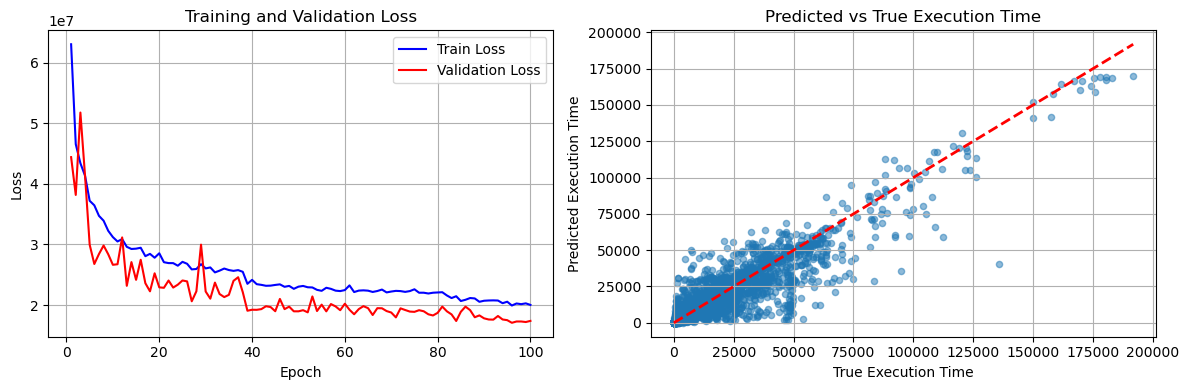

In [26]:

# 10. 可视化训练过程和结果
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(12, 4))
    
    # 训练损失曲线
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # 预测 vs 真实值
    plt.subplot(1, 2, 2)
    plt.scatter(targets, predictions, alpha=0.5, s=20)
    min_val = min(targets.min(), predictions.min())
    max_val = max(targets.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('True Execution Time')
    plt.ylabel('Predicted Execution Time')
    plt.title('Predicted vs True Execution Time')
    plt.grid(True)
    
    plt.tight_layout()
    date = datetime.now().strftime("%m%d")
    plt.savefig(f'../results/training_results_{date}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 创建结果目录
os.makedirs('../results', exist_ok=True)
# 绘制结果
plot_training_history(train_losses, val_losses)
